# CGAN: 
- Noise prior (latent vector) z gets concatted with y before it gets inputted into G. 
- Either x or G(z) gets concatted with y before it gets inputted into D.
- y is 'condition', which in this case is a class label.


- G(concat(emb(z), emb(y))): dim 1200 -> 784
- emb(z): dim 100 -> 200
- emb(y): dim 10 -> 1000


- D(concat(emb(x), emb(y))): dim 1200 -> 1
- emb(x): dim 784 -> 1000
- emb(y): dim 10 -> 200

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

from torchvision import transforms
from torchvision import datasets

import numpy as np
import easydict
import matplotlib.pyplot as plt

# Generator

In [ ]:
def normal_init(m, mean, std):
    if isinstance(m, nn.Linear):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.fc_z = nn.Linear(100, 200)
        self.relu = nn.LeakyReLU(0.1)

        self.fc_y = nn.Linear(10, 1000)
        self.relu = nn.LeakyReLU(0.1)

        self.fc_g = nn.Sequential(
            nn.Linear(1200, 1024),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(1024, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 784),          
        )
        self.sigmoid = nn.Sigmoid()
    
    def weight_init(self, mean, std):
        for m in self.modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input, label):

        z = self.fc_z(input)
        z = self.relu(z)

        y = self.fc_y(label)
        y = self.relu(y)

        x = torch.concat([z, y], dim=-1)
        x = self.fc_g(x)
        x = self.sigmoid(x)

        return x

# Discriminator

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc_x = nn.Linear(784, 1000)
        self.relu = nn.LeakyReLU(0.1)

        self.fc_y = nn.Linear(10, 200)
        self.relu = nn.LeakyReLU(0.1)

        self.fc_d = nn.Sequential(
            nn.Linear(1200, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 1),       
        )
        self.sigmoid = nn.Sigmoid()
    
    def weight_init(self, mean, std):
        for m in self.modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input, label):

        x = self.fc_x(input)
        x = self.relu(x)

        y = self.fc_y(label)
        y = self.relu(y)

        x = torch.concat([x, y], dim=-1)
        x = self.fc_d(x)
        x = self.sigmoid(x)

        return x

# Train

In [ ]:
parser = easydict.EasyDict(
    {
        "n_epochs": 50,
        "batch_size": 256,

        "lr_g": 1e-4,
        "lr_d": 1e-4,

        "b1": 0.5,
        "b2": 0.999,
        
        "n_cpu": 8,
        "latent_dim": 100, 
        "n_classes": 10,
        "img_size": 28,
        "channels": 1,
        "sample_interval": 2
    }
)

In [ ]:
def sample_image(n_row, epoch):
    
    # noise prior z
    z = torch.randn(n_row, parser['latent_dim']).type(torch.FloatTensor).cuda()
    # gen label y
    gen_labels = []
    for randpos in range(0, n_row):
        gen_labels.append(torch.eye(parser['n_classes'])[randpos])
    gen_labels = torch.stack(gen_labels).cuda()

    generator.eval()
    
    gen_imgs = generator(z, gen_labels)

    plt.figure(figsize=(10, 5))
    for i, img in enumerate(gen_imgs.detach().cpu().numpy().reshape(n_row, parser['img_size'], parser['img_size'])):
        plt.subplot(1, n_row, i+1)
        plt.imshow(img)
        plt.title(str(i))
        plt.axis('off')
    plt.show()

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.], [1.])
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=parser['batch_size'], 
    shuffle=True,
    drop_last=True,
    )

In [ ]:
cross_entropy = torch.nn.BCELoss().cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=parser['lr_g'], betas=(parser['b1'], parser['b2']))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=parser['lr_d'], betas=(parser['b1'], parser['b2']))

Train Epoch: [0/50]  Step: [0/234]   G loss: 0.71105  D loss: 0.69231  
Train Epoch: [0/50]  Step: [100/234] G loss: 1.45868  D loss: 0.37036  
Train Epoch: [0/50]  Step: [200/234] G loss: 2.47582  D loss: 0.15453  


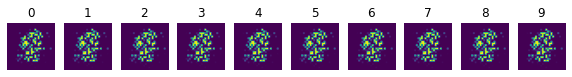

Train Epoch: [1/50]  Step: [0/234]   G loss: 2.63899  D loss: 0.14396  
Train Epoch: [1/50]  Step: [100/234] G loss: 3.31654  D loss: 0.07490  
Train Epoch: [1/50]  Step: [200/234] G loss: 3.69555  D loss: 0.05794  
Train Epoch: [2/50]  Step: [0/234]   G loss: 3.65832  D loss: 0.06623  
Train Epoch: [2/50]  Step: [100/234] G loss: 4.83466  D loss: 0.04006  
Train Epoch: [2/50]  Step: [200/234] G loss: 5.89114  D loss: 0.01958  


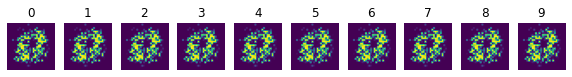

Train Epoch: [3/50]  Step: [0/234]   G loss: 4.31711  D loss: 0.06035  
Train Epoch: [3/50]  Step: [100/234] G loss: 4.70883  D loss: 0.03018  
Train Epoch: [3/50]  Step: [200/234] G loss: 6.53836  D loss: 0.00835  
Train Epoch: [4/50]  Step: [0/234]   G loss: 6.26667  D loss: 0.02079  
Train Epoch: [4/50]  Step: [100/234] G loss: 5.13368  D loss: 0.01072  
Train Epoch: [4/50]  Step: [200/234] G loss: 9.78436  D loss: 0.00812  


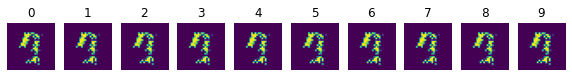

Train Epoch: [5/50]  Step: [0/234]   G loss: 4.49393  D loss: 0.03215  
Train Epoch: [5/50]  Step: [100/234] G loss: 9.37240  D loss: 0.01428  
Train Epoch: [5/50]  Step: [200/234] G loss: 5.76169  D loss: 0.00659  
Train Epoch: [6/50]  Step: [0/234]   G loss: 5.87885  D loss: 0.00644  
Train Epoch: [6/50]  Step: [100/234] G loss: 4.72045  D loss: 0.02650  
Train Epoch: [6/50]  Step: [200/234] G loss: 5.75114  D loss: 0.00922  


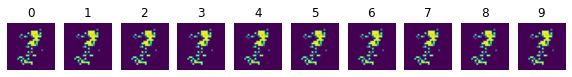

Train Epoch: [7/50]  Step: [0/234]   G loss: 6.10009  D loss: 0.00506  
Train Epoch: [7/50]  Step: [100/234] G loss: 4.69276  D loss: 0.01901  
Train Epoch: [7/50]  Step: [200/234] G loss: 5.69211  D loss: 0.01094  
Train Epoch: [8/50]  Step: [0/234]   G loss: 4.77000  D loss: 0.04108  
Train Epoch: [8/50]  Step: [100/234] G loss: 5.05678  D loss: 0.02920  
Train Epoch: [8/50]  Step: [200/234] G loss: 6.05098  D loss: 0.01075  


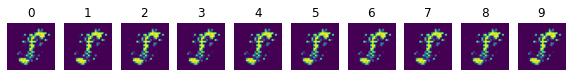

Train Epoch: [9/50]  Step: [0/234]   G loss: 9.63197  D loss: 0.00430  
Train Epoch: [9/50]  Step: [100/234] G loss: 5.48064  D loss: 0.02316  
Train Epoch: [9/50]  Step: [200/234] G loss: 9.25826  D loss: 0.02307  
Train Epoch: [10/50] Step: [0/234]   G loss: 6.21052  D loss: 0.00624  
Train Epoch: [10/50] Step: [100/234] G loss: 4.06607  D loss: 0.05351  
Train Epoch: [10/50] Step: [200/234] G loss: 6.82957  D loss: 0.02055  


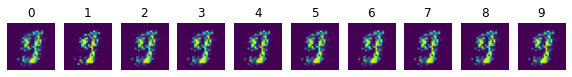

Train Epoch: [11/50] Step: [0/234]   G loss: 5.86537  D loss: 0.00933  
Train Epoch: [11/50] Step: [100/234] G loss: 4.24464  D loss: 0.05355  
Train Epoch: [11/50] Step: [200/234] G loss: 5.66354  D loss: 0.02664  
Train Epoch: [12/50] Step: [0/234]   G loss: 5.08215  D loss: 0.01954  
Train Epoch: [12/50] Step: [100/234] G loss: 5.74354  D loss: 0.02755  
Train Epoch: [12/50] Step: [200/234] G loss: 5.80591  D loss: 0.02967  


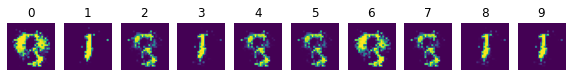

Train Epoch: [13/50] Step: [0/234]   G loss: 5.34781  D loss: 0.02881  
Train Epoch: [13/50] Step: [100/234] G loss: 6.31848  D loss: 0.02615  
Train Epoch: [13/50] Step: [200/234] G loss: 5.82403  D loss: 0.01354  
Train Epoch: [14/50] Step: [0/234]   G loss: 5.68920  D loss: 0.01129  
Train Epoch: [14/50] Step: [100/234] G loss: 5.50671  D loss: 0.01343  
Train Epoch: [14/50] Step: [200/234] G loss: 5.64868  D loss: 0.01354  


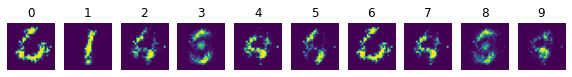

Train Epoch: [15/50] Step: [0/234]   G loss: 6.35182  D loss: 0.02544  
Train Epoch: [15/50] Step: [100/234] G loss: 5.40181  D loss: 0.01039  
Train Epoch: [15/50] Step: [200/234] G loss: 4.70554  D loss: 0.02241  
Train Epoch: [16/50] Step: [0/234]   G loss: 5.78369  D loss: 0.01719  
Train Epoch: [16/50] Step: [100/234] G loss: 5.99037  D loss: 0.01008  
Train Epoch: [16/50] Step: [200/234] G loss: 5.99464  D loss: 0.02881  


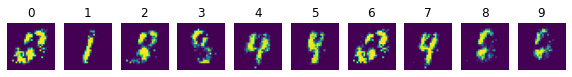

Train Epoch: [17/50] Step: [0/234]   G loss: 4.34258  D loss: 0.04551  
Train Epoch: [17/50] Step: [100/234] G loss: 6.21057  D loss: 0.01429  
Train Epoch: [17/50] Step: [200/234] G loss: 4.77260  D loss: 0.02111  
Train Epoch: [18/50] Step: [0/234]   G loss: 6.03741  D loss: 0.01952  
Train Epoch: [18/50] Step: [100/234] G loss: 6.24231  D loss: 0.04885  
Train Epoch: [18/50] Step: [200/234] G loss: 4.37146  D loss: 0.03099  


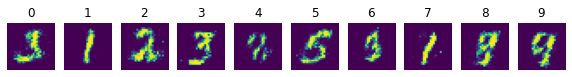

Train Epoch: [19/50] Step: [0/234]   G loss: 4.98698  D loss: 0.03787  
Train Epoch: [19/50] Step: [100/234] G loss: 5.76139  D loss: 0.01058  
Train Epoch: [19/50] Step: [200/234] G loss: 5.66656  D loss: 0.02789  
Train Epoch: [20/50] Step: [0/234]   G loss: 7.03963  D loss: 0.05678  
Train Epoch: [20/50] Step: [100/234] G loss: 5.60162  D loss: 0.02568  
Train Epoch: [20/50] Step: [200/234] G loss: 5.03253  D loss: 0.03839  


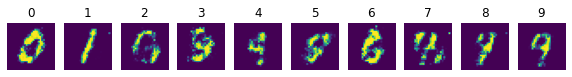

Train Epoch: [21/50] Step: [0/234]   G loss: 5.90821  D loss: 0.03469  
Train Epoch: [21/50] Step: [100/234] G loss: 5.30706  D loss: 0.03843  
Train Epoch: [21/50] Step: [200/234] G loss: 5.30952  D loss: 0.02684  
Train Epoch: [22/50] Step: [0/234]   G loss: 5.85314  D loss: 0.02931  
Train Epoch: [22/50] Step: [100/234] G loss: 4.13527  D loss: 0.05149  
Train Epoch: [22/50] Step: [200/234] G loss: 5.52304  D loss: 0.03868  


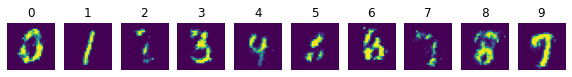

Train Epoch: [23/50] Step: [0/234]   G loss: 5.22715  D loss: 0.05053  
Train Epoch: [23/50] Step: [100/234] G loss: 5.13715  D loss: 0.04642  
Train Epoch: [23/50] Step: [200/234] G loss: 3.49085  D loss: 0.06655  
Train Epoch: [24/50] Step: [0/234]   G loss: 4.52160  D loss: 0.03736  
Train Epoch: [24/50] Step: [100/234] G loss: 4.52137  D loss: 0.04649  
Train Epoch: [24/50] Step: [200/234] G loss: 4.13998  D loss: 0.07572  


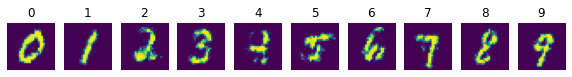

Train Epoch: [25/50] Step: [0/234]   G loss: 4.60474  D loss: 0.03786  
Train Epoch: [25/50] Step: [100/234] G loss: 3.75065  D loss: 0.05432  
Train Epoch: [25/50] Step: [200/234] G loss: 4.51440  D loss: 0.05134  
Train Epoch: [26/50] Step: [0/234]   G loss: 5.67663  D loss: 0.09252  
Train Epoch: [26/50] Step: [100/234] G loss: 4.48634  D loss: 0.05388  
Train Epoch: [26/50] Step: [200/234] G loss: 3.76439  D loss: 0.06889  


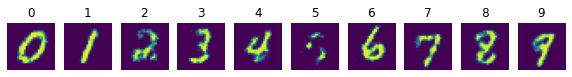

Train Epoch: [27/50] Step: [0/234]   G loss: 5.52503  D loss: 0.20810  
Train Epoch: [27/50] Step: [100/234] G loss: 3.44441  D loss: 0.09499  
Train Epoch: [27/50] Step: [200/234] G loss: 3.97561  D loss: 0.11964  
Train Epoch: [28/50] Step: [0/234]   G loss: 2.99619  D loss: 0.15586  
Train Epoch: [28/50] Step: [100/234] G loss: 3.77024  D loss: 0.14274  
Train Epoch: [28/50] Step: [200/234] G loss: 3.58715  D loss: 0.13523  


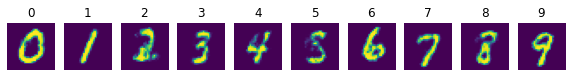

Train Epoch: [29/50] Step: [0/234]   G loss: 3.32599  D loss: 0.11142  
Train Epoch: [29/50] Step: [100/234] G loss: 3.13059  D loss: 0.17361  
Train Epoch: [29/50] Step: [200/234] G loss: 4.49736  D loss: 0.22731  
Train Epoch: [30/50] Step: [0/234]   G loss: 3.27040  D loss: 0.13708  
Train Epoch: [30/50] Step: [100/234] G loss: 3.72768  D loss: 0.14075  
Train Epoch: [30/50] Step: [200/234] G loss: 3.48384  D loss: 0.12882  


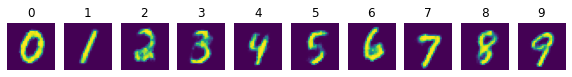

Train Epoch: [31/50] Step: [0/234]   G loss: 5.17842  D loss: 0.29187  
Train Epoch: [31/50] Step: [100/234] G loss: 3.42044  D loss: 0.16036  
Train Epoch: [31/50] Step: [200/234] G loss: 3.02179  D loss: 0.13779  
Train Epoch: [32/50] Step: [0/234]   G loss: 2.82698  D loss: 0.15803  
Train Epoch: [32/50] Step: [100/234] G loss: 4.30279  D loss: 0.14846  
Train Epoch: [32/50] Step: [200/234] G loss: 4.22795  D loss: 0.21373  


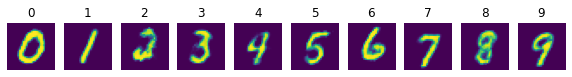

Train Epoch: [33/50] Step: [0/234]   G loss: 3.12130  D loss: 0.17418  
Train Epoch: [33/50] Step: [100/234] G loss: 3.41671  D loss: 0.16304  
Train Epoch: [33/50] Step: [200/234] G loss: 3.75149  D loss: 0.17008  
Train Epoch: [34/50] Step: [0/234]   G loss: 1.64299  D loss: 0.35032  
Train Epoch: [34/50] Step: [100/234] G loss: 4.41441  D loss: 0.22675  
Train Epoch: [34/50] Step: [200/234] G loss: 3.87021  D loss: 0.13864  


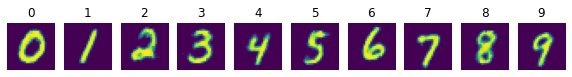

Train Epoch: [35/50] Step: [0/234]   G loss: 2.87957  D loss: 0.13772  
Train Epoch: [35/50] Step: [100/234] G loss: 3.14747  D loss: 0.14506  
Train Epoch: [35/50] Step: [200/234] G loss: 4.04566  D loss: 0.23359  
Train Epoch: [36/50] Step: [0/234]   G loss: 2.89641  D loss: 0.14670  
Train Epoch: [36/50] Step: [100/234] G loss: 3.00057  D loss: 0.12432  
Train Epoch: [36/50] Step: [200/234] G loss: 3.34251  D loss: 0.16471  


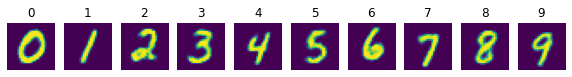

Train Epoch: [37/50] Step: [0/234]   G loss: 3.11085  D loss: 0.15922  
Train Epoch: [37/50] Step: [100/234] G loss: 4.23325  D loss: 0.25844  
Train Epoch: [37/50] Step: [200/234] G loss: 2.69670  D loss: 0.19495  
Train Epoch: [38/50] Step: [0/234]   G loss: 4.65220  D loss: 0.27191  
Train Epoch: [38/50] Step: [100/234] G loss: 3.13273  D loss: 0.16445  
Train Epoch: [38/50] Step: [200/234] G loss: 3.23249  D loss: 0.15820  


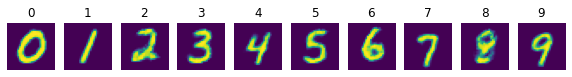

Train Epoch: [39/50] Step: [0/234]   G loss: 3.54840  D loss: 0.17349  
Train Epoch: [39/50] Step: [100/234] G loss: 3.43024  D loss: 0.20400  
Train Epoch: [39/50] Step: [200/234] G loss: 2.37048  D loss: 0.16691  
Train Epoch: [40/50] Step: [0/234]   G loss: 3.38837  D loss: 0.15360  
Train Epoch: [40/50] Step: [100/234] G loss: 3.03506  D loss: 0.17322  
Train Epoch: [40/50] Step: [200/234] G loss: 2.34852  D loss: 0.19946  


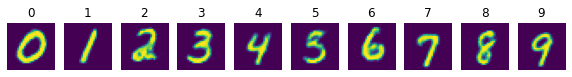

Train Epoch: [41/50] Step: [0/234]   G loss: 2.98206  D loss: 0.15144  
Train Epoch: [41/50] Step: [100/234] G loss: 2.70143  D loss: 0.19924  
Train Epoch: [41/50] Step: [200/234] G loss: 3.16548  D loss: 0.20793  
Train Epoch: [42/50] Step: [0/234]   G loss: 2.64807  D loss: 0.20766  
Train Epoch: [42/50] Step: [100/234] G loss: 2.84458  D loss: 0.22444  
Train Epoch: [42/50] Step: [200/234] G loss: 3.13139  D loss: 0.16081  


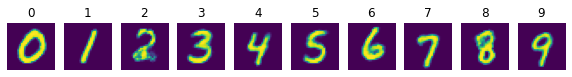

Train Epoch: [43/50] Step: [0/234]   G loss: 2.81257  D loss: 0.19689  
Train Epoch: [43/50] Step: [100/234] G loss: 2.57303  D loss: 0.18711  
Train Epoch: [43/50] Step: [200/234] G loss: 3.68292  D loss: 0.23655  
Train Epoch: [44/50] Step: [0/234]   G loss: 2.47964  D loss: 0.19894  
Train Epoch: [44/50] Step: [100/234] G loss: 2.73238  D loss: 0.19660  
Train Epoch: [44/50] Step: [200/234] G loss: 2.71638  D loss: 0.19764  


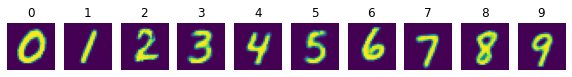

Train Epoch: [45/50] Step: [0/234]   G loss: 2.52282  D loss: 0.20798  
Train Epoch: [45/50] Step: [100/234] G loss: 3.75128  D loss: 0.29880  
Train Epoch: [45/50] Step: [200/234] G loss: 2.97154  D loss: 0.22970  
Train Epoch: [46/50] Step: [0/234]   G loss: 2.88662  D loss: 0.20270  
Train Epoch: [46/50] Step: [100/234] G loss: 2.36367  D loss: 0.22734  
Train Epoch: [46/50] Step: [200/234] G loss: 2.44688  D loss: 0.19237  


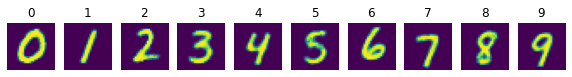

Train Epoch: [47/50] Step: [0/234]   G loss: 2.37393  D loss: 0.20904  
Train Epoch: [47/50] Step: [100/234] G loss: 3.23469  D loss: 0.23725  
Train Epoch: [47/50] Step: [200/234] G loss: 2.90878  D loss: 0.18253  
Train Epoch: [48/50] Step: [0/234]   G loss: 2.09440  D loss: 0.24674  
Train Epoch: [48/50] Step: [100/234] G loss: 2.46299  D loss: 0.17710  
Train Epoch: [48/50] Step: [200/234] G loss: 2.74247  D loss: 0.24248  


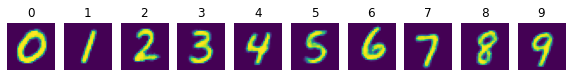

Train Epoch: [49/50] Step: [0/234]   G loss: 2.16889  D loss: 0.23843  
Train Epoch: [49/50] Step: [100/234] G loss: 2.71979  D loss: 0.20271  
Train Epoch: [49/50] Step: [200/234] G loss: 2.17053  D loss: 0.23541  


In [ ]:
discriminator.train()

g_loss = torch.Tensor([0])
d_loss = torch.Tensor([0])

for epoch in range(parser['n_epochs']):

    for batch_idx, (x, y) in enumerate(train_loader):

        d_label_real = torch.ones(parser['batch_size'], 1).cuda()
        d_label_fake = torch.zeros(parser['batch_size'], 1).cuda()


        # noise prior z
        z = torch.randn(parser['batch_size'], parser['latent_dim']).cuda()
        # gen label y
        gen_labels = []
        for randpos in np.random.randint(0, parser['n_classes'], parser['batch_size']):
            gen_labels.append(torch.eye(parser['n_classes'])[randpos])
        gen_labels = torch.stack(gen_labels).cuda()

        # G train
        generator.train()
        # G zero_grad
        optimizer_G.zero_grad()
        # G forward prop
        gen_imgs = generator(z, gen_labels)
        # DG forward prop
        d_output_gen = discriminator(gen_imgs, gen_labels)
        # G loss
        g_loss = cross_entropy(d_output_gen, d_label_real)
        # G backprop
        g_loss.backward()
        # G gd
        optimizer_G.step() 
    

        # MNIST data x
        x = x.view(x.shape[0], -1).type(torch.FloatTensor).cuda()
        # real label y
        real_labels = torch.nn.functional.one_hot(y, num_classes=parser['n_classes']).type(torch.FloatTensor).cuda()

        # D zero_grad
        optimizer_D.zero_grad()
        # DR forward prop
        d_output_real = discriminator(x, real_labels)
        # DR loss
        d_loss_real = cross_entropy(d_output_real, d_label_real)
        # DG forward prop
        d_output_fake = discriminator(gen_imgs.detach(), gen_labels)
        # DG loss
        d_loss_fake = cross_entropy(d_output_fake, d_label_fake)
        # D combined loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        # D backprop
        d_loss.backward()
        # D gd
        optimizer_D.step()


        if batch_idx%100==0:
            print('{:<13s}{:<8s}{:<6s}{:<10s}{:<8s}{:<9.5f}{:<8s}{:<9.5f}'.format('Train Epoch: ', '[' + str(epoch) + '/' + str(parser['n_epochs']) + ']', 'Step: ', '[' + str(batch_idx) + '/' + str(len(train_loader)) + ']', 'G loss: ', g_loss.item(), 'D loss: ', d_loss.item()))

    if epoch%parser['sample_interval']==0:
        sample_image(n_row=10, epoch=epoch)